In [43]:
from IPython.display import HTML
from IPython.display import Image

Retinal images
----------

<img src='glaucomapicture.jpg' width="300" height="300" align="left">

In [2]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Project: Glaucoma Detection
=======

**By: Pieter Leffers**

*Starting Date: March 1, 2019*

*Completion Date: -, 2019*

*Last Updated: April 30, 2019*

**Project Description**
--------

According to the  American Optometric Association, Glaucoma is a general term for a number of eye conditions that progressively damage the optic nerve,consequently causing vision loss. Diagnosis of glaucoma is complex, but is often associated with elevated intraocular pressure, optic nerve damage, and reduction in visual acuity and visual field. Vision loss from glaucoma is permanent, but progression may be slowed or halted through early diagnosis and treatment.

 
 
 
 American Optometric Association. Glossary of Common Eye & Vision Conditions website.
https://www.aoa.org/patients-and-public/eye-and-vision-problems/glossary-of-eye-and-vision-conditions. Accessed June 7, 2018.

**Data Source: **


For this project I will use data gathered from the Harvard Dataverse collected and uploaded by Ungsoo Kim. The retinal image dataset consists of 788 ‘normal control’ images, 289 ‘early stage’ images, and 467 ‘advanced stage’ images.The images are already preprocessed, (scaled to 800 pixels and cropped so the nerve endings are of 240 pixels) thus ready to be used for machine learning tasks. However, this dataset will present itself particularly challenging as the number of retinal images needed for this task are less than desirable; thus representing a real-world problem of its own.

The data was originally collected from Kim's Eye Hospital. The images have already been pre-processed and fixed to a size of 800 pixels, centered on the optic nerve, and cropped to a size of 240 pixels.

The data is hosted on the Harvard Dataverse and can be downloaded at:
*Kim, Ungsoo, 2018, "Machine learn for glaucoma", https://doi.org/10.7910/DVN/1YRRAC, Harvard Dataverse, V1 *


**Note:** I will need to keep in mind folder structure in the future since I will be porting to sagemaker with a Dockerfile and the folder structure for Sagemaker is particularly important.

*Setup Folder Tree*

    sage
    ├── Dockerfile
    ├── local_test
    │  ├── predict.sh
    │  ├── train.sh
    │  ├── serve.sh
    │  └── test_dir => /opt/ml in container
    │      ├── input
    │      │   ├── config
    │      │   └── data
    │      │       └── training
    │      ├── model
    │      └── output
    └── program
        ├── (some scripts...)
        ├── train
        └── serve

**Import Packages**

In [1]:
import random
import shutil
import numpy as np
import os
import imgaug
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
import random
from imgaug import augmenters as iaa
import imageio
import imgaug as ia

%matplotlib inline

ver=cv2.__version__
print('Matplotlib Version: {}'.format(matplotlib.__version__))
if float(ver[0])==3 and float(ver[-3:])<4.2:
    print('Please update OpenCV. This requires a minimum of OpenCV 3.4.2')
    print('Your current version is: ',cv2.__version__)
elif float(ver[0])>3:
    print('OpenCV Version:',cv2.__version__) 
else:
    print('OpenCV Version:',cv2.__version__)

Matplotlib Version: 2.2.2
OpenCV Version: 4.0.0


*Make folders*

In [2]:
DirList=['./local_test','./program',\
         './local_test/test_dir',\
         './local_test/test_dir/input',\
         './local_test/test_dir/input/config',\
         './local_test/test_dir/input/data',\
         './local_test/test_dir/input/data/training',\
         './local_test/test_dir/input/data/training/augmentation',\
         './local_test/test_dir/model',\
         './local_test/test_dir/output',\
         './local_test/program',
         './local_test/program/train',
         './local_test/program/serve',\
         './local_test/test_dir/input/data/images']#can add more folders I want to create in this process
for i in DirList:
    try:
        # Create target Directory
        os.mkdir(i)
        print("Directory " ,i,  " Created ") 
    except:
        print("Directory " ,i,  " already exists")

Directory  ./local_test  Created 
Directory  ./program  Created 
Directory  ./local_test/test_dir  Created 
Directory  ./local_test/test_dir/input  Created 
Directory  ./local_test/test_dir/input/config  Created 
Directory  ./local_test/test_dir/input/data  Created 
Directory  ./local_test/test_dir/input/data/training  Created 
Directory  ./local_test/test_dir/input/data/training/augmentation  Created 
Directory  ./local_test/test_dir/model  Created 
Directory  ./local_test/test_dir/output  Created 
Directory  ./local_test/program  Created 
Directory  ./local_test/program/train  Created 
Directory  ./local_test/program/serve  Created 
Directory  ./local_test/test_dir/input/data/images  Created 


*Pull Data*

In [3]:
#Takes a couple of hours to download
#!wget https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/1YRRAC/OGRSQO

*Extract Data*

*I am supressing the output in order to conserve space. I have printed the first 5 lines of the output to give you an idea of what is happening.*

In [4]:
%%capture captured
!unzip processed_data.zip -d ./local_test/test_dir/input/data/images

In [5]:
file_out=captured.stdout

In [6]:
print(file_out[:420])

Archive:  processed_data.zip
  inflating: ./local_test/test_dir/input/data/images/data_description.txt  
   creating: ./local_test/test_dir/input/data/images/advanced_glaucoma/
  inflating: ./local_test/test_dir/input/data/images/advanced_glaucoma/1.png  
  inflating: ./local_test/test_dir/input/data/images/advanced_glaucoma/10.png  
  inflating: ./local_test/test_dir/input/data/images/advanced_glaucoma/100.png 


*Setup Training, Testing, and Validation Folders*

In [7]:
!mv ./local_test/test_dir/input/data/images/advanced_glaucoma/* ./local_test/test_dir/input/data/images/early_glaucoma
!mv ./local_test/test_dir/input/data/images/early_glaucoma ./local_test/test_dir/input/data/images/cases
!mv ./local_test/test_dir/input/data/images/normal_control ./local_test/test_dir/input/data/images/controls
!rm -r ./local_test/test_dir/input/data/images/advanced_glaucoma/

Setup Data Structure
--------

In [8]:
#Create training, testing, validation function, as well as a percentage for data augmentation of each

# the path to the original images
input_data_folder = "local_test/test_dir/input/data/images"
# new directory that will contain our images after computing the training and testing split
data_folder_name = "local_test/test_dir/input/data/training"

# define the percentage of the data that will be used training
training_percent = 0.8

# the amount of validation data will be a percentage of the *training* data
validation_percent = 0.1

#the amount of augmentation needed for images
augment_percent = 0.2

The two functions below were pulled from imgauge github page because I couldn't import them from the library.

In [9]:
def do_assert(condition, message="Assertion failed."):
    """
    Function that behaves equally to an `assert` statement, but raises an
    Exception.
    This is added because `assert` statements are removed in optimized code.
    It replaces `assert` statements throughout the library that should be
    kept even in optimized code.
    Parameters
    ----------
    condition : bool
        If False, an exception is raised.
    message : str, optional
        Error message.
    """
    if not condition:
        raise AssertionError(str(message))

IMSHOW_BACKEND_DEFAULT = "matplotlib"
def imshow(image, backend=IMSHOW_BACKEND_DEFAULT):
    """
    Shows an image in a window.
    dtype support::
        * ``uint8``: yes; not tested
        * ``uint16``: ?
        * ``uint32``: ?
        * ``uint64``: ?
        * ``int8``: ?
        * ``int16``: ?
        * ``int32``: ?
        * ``int64``: ?
        * ``float16``: ?
        * ``float32``: ?
        * ``float64``: ?
        * ``float128``: ?
        * ``bool``: ?
    Parameters
    ----------
    image : (H,W,3) ndarray
        Image to show.
    backend : {'matplotlib', 'cv2'}, optional
        Library to use to show the image. May be either matplotlib or OpenCV ('cv2').
        OpenCV tends to be faster, but apparently causes more technical issues.
    """
    do_assert(backend in ["matplotlib", "cv2"], "Expected backend 'matplotlib' or 'cv2', got %s." % (backend,))

    if backend == "cv2":
        image_bgr = image
        if image.ndim == 3 and image.shape[2] in [3, 4]:
            image_bgr = image[..., 0:3][..., ::-1]

        win_name = "imgaug-default-window"
        cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
        cv2.imshow(win_name, image_bgr)
        cv2.waitKey(0)
        cv2.destroyWindow(win_name)
    else:
        # import only when necessary (faster startup; optional dependency; less fragile -- see issue #225)
        import matplotlib.pyplot as plt

        dpi = 96
        h, w = image.shape[0] / dpi, image.shape[1] / dpi
        w = max(w, 6)  # if the figure is too narrow, the footer may appear and make the fig suddenly wider (ugly)
        fig, ax = plt.subplots(figsize=(w, h), dpi=dpi)
        fig.canvas.set_window_title("imgaug.imshow(%s)" % (image.shape,))
        ax.imshow(image, cmap="gray")  # cmap is only activate for grayscale images
plt.show()

Build Training, Testing, and Validation Datasets
---------

Here I have created a class object so that I may consider creating a library for my needs. For the time being it is convenient to be able to simply execute the functions below with a single command. Since I was already planning on going through the trouble of supplementing images in the training set with image augmentation I decided to fold it into the same procedure as creating the training, testing, and validation sets. 

In [10]:
class preprocess_data(object):

    def create_train_test_val(data_folder_name):
        '''
        Points to the folders specified. 
        '''
        # setup the training, validation, and testing directories
        training_folder = os.path.sep.join([data_folder_name, "training"])
        validation_folder = os.path.sep.join([data_folder_name, "validation"])
        testing_folder  = os.path.sep.join([data_folder_name, "testing"])
        return training_folder,validation_folder,testing_folder

    def list_images(data_folder, contains=None):
        # import the necessary packages
        image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
        # return the set of files that are valid
        return preprocess_data.list_files(data_folder, valid_extensions=image_types, contains=contains)

    def list_files(data_folder, valid_extensions=None, contains=None):
        # loop over the directory structure
        for (root_directory, directory_names, filenames) in os.walk(data_folder):
            # loop over the filenames in the current directory
            for filename in filenames:
                # if the contains string is not none and the filename does not contain
                # the supplied string, then ignore the file
                if contains is not None and filename.find(contains) == -1:
                    continue

                # determine the file extension of the current file
                extension = filename[filename.rfind("."):].lower()

                # check to see if the file is an image and should be processed
                if valid_extensions is None or extension.endswith(valid_extensions):
                    # construct the path to the image and yield it
                    image_paths = os.path.join(root_directory, filename)
                    yield image_paths

    def images_augment(augment_percent,training_paths):
        aug_num=int(len(training_paths) * augment_percent)
        for image_iter in training_paths[:aug_num]:
            #filename,extension = (os.path.splitext(os.path.basename(image_iter)))
            #path,fullname=os.path.split(image_iter) 
            path='./local_test/test_dir/input/data/training/augmentation'
            imread_image = imageio.imread(image_iter)
            random_num=random.randint(0,360)
            rotate = iaa.Affine(rotate=(-random_num, random_num))
            image_aug = rotate.augment_image(imread_image)
            #imshow(image_aug)
            imageio.imwrite(path+'/aug_image_iter_'+str(random_num)+'.png',image_aug)
        return aug_num

    def setup_folders(training_percent,validation_percent,augment_percent):
        training_folder,validation_folder,testing_folder=preprocess_data.create_train_test_val(data_folder_name)
        # grab the paths to all input images in the original input directory and shuffle them
        image_paths = list(preprocess_data.list_images(input_data_folder))
        random.shuffle(image_paths)

        # training and testing split
        comparison = int(len(image_paths) * training_percent)
        training_paths = image_paths[:comparison]
        testing_paths = image_paths[comparison:]

        # using part of the training data for validation
        comparison = int(len(training_paths) * validation_percent)
        validation_paths = training_paths[:comparison]
        training_paths = training_paths[comparison:]  

        print('Images selected for training folder: ',len(training_paths))
        print('Images selected for testing folder: ',len(testing_paths))
        print('Images selected for validation folder: ',len(validation_paths))

        # define the datasets that we'll be building
        datasets = [("training", training_paths, training_folder),
                    ("validation", validation_paths, validation_folder),
                    ("testing", testing_paths, testing_folder)]
        
        # loop over the datasets
        for (data_type, image_paths, output_folder) in datasets:
            # show which data split we are creating
            print("\nbuilding "+data_type+" collection . . .\n")

            # if the output base output directory does not exist, create it
            if not os.path.exists(output_folder):
                print("creating "+data_type+" directory . . .")
                os.makedirs(output_folder)

            # loop over the input image paths
            for path in image_paths:
                # extract the filename of the input image along with its corresponding class label
                filename = path.split(os.path.sep)[-1]
                label = path.split(os.path.sep)[-2]
                # build the path to the label directory
                label_paths = os.path.sep.join([output_folder, label])

                # if the label output directory does not exist, create it
                if not os.path.exists(label_paths):
                    print("creating "+data_type+" directory . . .")
                    os.makedirs(label_paths)

                # construct the path to the destination image and then copy the image itself
                p = os.path.sep.join([label_paths, filename])
                shutil.copy2(path, p) #Identical to copy() except that copy2() also attempts to preserve file metadata.
                
        aug_num=preprocess_data.images_augment(augment_percent,training_paths)
        # return the total number of image paths in training, validation, and testing directories
        training_total = len(list(preprocess_data.list_images(training_folder)))
        validation_total = len(list(preprocess_data.list_images(validation_folder)))
        testing_total = len(list(preprocess_data.list_images(testing_folder)))
        total_images=training_total+validation_total+testing_total
        print('\nTraining Images: ',training_total,'\nValidation Images: ',
              validation_total,'\nTesting Images: ',testing_total,
              '\nTotal Images Selected: ',total_images,'\nAugmented Images Added: ',aug_num)
        
        return training_paths

In [11]:
training_path=preprocess_data.setup_folders(training_percent,validation_percent,augment_percent)

Images selected for training folder:  904
Images selected for testing folder:  251
Images selected for validation folder:  100

building training collection . . .

creating training directory . . .
creating training directory . . .
creating training directory . . .

building validation collection . . .

creating validation directory . . .
creating validation directory . . .
creating validation directory . . .

building testing collection . . .

creating testing directory . . .
creating testing directory . . .
creating testing directory . . .

Training Images:  904 
Validation Images:  100 
Testing Images:  251 
Total Images Selected:  1255 
Augmented Images Added:  180


I have created 180 images to help supplement my lack of images in the training folder. The reason it is merely 180 images and not more images is to avoid the augmented images being too statistically representative within the image dataset and thereby biasing the results. Below is a simple representation of the function I'm using within the class object above. 

Augmented batch:


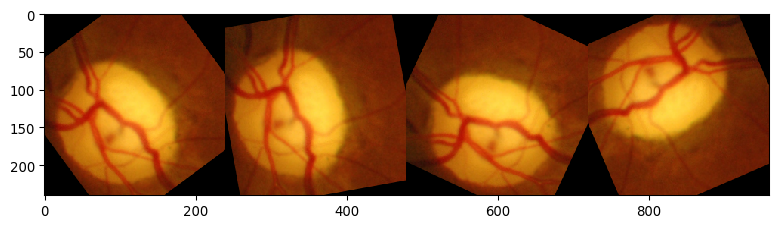

In [12]:
image = imageio.imread("local_test/test_dir/input/data/images/cases/6.png")
random_num=random.randint(0,360)
rotate = iaa.Affine(rotate=(-random_num, random_num))
images = [image, image, image, image]
images_aug = rotate.augment_images(images)

print("Augmented batch:")
imshow(np.hstack(images_aug))

Define Model Structure
=====

For classification of retinal images I have chosen to use a ResNet model as described by Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun in <a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">***Deep Residual Learning for Image Recognition (2015)***</a> and Adrian Rosebrock in <a href="http://www.i-element.org/PDF/C12-3.pdf" target="_blank">***Deep Learning for Computer Vision with Python (2017)***</a>. 

For an excellent explanation of the ResNet model, checkout Gracelyn Shi's Medium blog post:
https://towardsdatascience.com/implementing-a-resnet-model-from-scratch-971be7193718

**Why use a Residual Network (ResNet) model?**

In traditional Deep Neural Networks during training you typically run into problems during backpropagation while using gradient descent optimization; where the data is fed from the final layers back into the first initial activation layers. As the loss function (error) with respect to the weights becomes updated certain activation functions such as the sigmoid function, constrain the input space between 0 and 1. Since the gradient in a Neural Network is a product of the gradients preceeding it, multiplying two smaller numbers returns an even smaller number. The small change in the gradient causes training times to be painfully slow, prone to error, and adding a large number of layers to become too costly and prohibitive.



*Backpropagation:*

    Moving from later stages and fed back through the Neural Network to the initial layers.

Residual Networks provide a convenient solution to the 'vanishing gradient' problem. By skipping (shortcut) the training of one or more layers and creating a **residual block**.


<img src='relu.png' width="300" height="300" align="left">

In [13]:
#H(x) = F(x) + x, where F(x) = W2*relu(W1*x+b1)+b2

Model Architecture Map
-----

With the application of Batch Normalization, Activation Function, and Convolutional Layers along with shortcuts. We can now create a network as deep as we desire.

<img src='resnet_structure.jpg' width="500" height="500" align="left">

In [14]:
def residual_module(input_data, kernel, stride, axis, reduce=False, reg_lambda=0.0001, epsilon=0.00002, momentum=0.9):
    shortcut = input_data
    bn1 = BatchNormalization(axis=axis, epsilon=epsilon, momentum=momentum)(input_data)
    act1 = Activation("relu")(bn1)
    conv1 = Conv2D(int(kernel * 0.25), (1, 1), use_bias=False,kernel_regularizer=l2(reg_lambda))(act1)

    bn2 = BatchNormalization(axis=axis, epsilon=epsilon,momentum=momentum)(conv1)
    act2 = Activation("relu")(bn2)
    conv2 = Conv2D(int(kernel * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg_lambda))(act2)

    bn3 = BatchNormalization(axis=axis, epsilon=epsilon, momentum=momentum)(conv2)
    act3 = Activation("relu")(bn3)
    conv3 = Conv2D(kernel, (1, 1), use_bias=False, kernel_regularizer=l2(reg_lambda))(act3)

    if reduce: 
        shortcut = Conv2D(kernel, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg_lambda))(act1)

    x = add([conv3, shortcut])
    return x

Build Model Structure
=====

In [17]:
def build(width, height, depth, classes, stages, filters, reg_lambda=0.0001, epsilon=0.00002, momentum=0.9):
    input_shape = (height, width, depth)
    axis = -1

    if K.image_data_format() == "channels_first":
        input_shape = (depth, height, width)
        channel_dimension = 1

    inputs = Input(shape=input_shape)
    x = BatchNormalization(axis=axis, epsilon=epsilon,momentum=momentum)(inputs)
    x = Conv2D(filters[0], (5, 5), use_bias=False,padding="same", kernel_regularizer=l2(reg_lambda))(x)
    x = BatchNormalization(axis=axis, epsilon=epsilon,momentum=momentum)(x)
    x = Activation("relu")(x)
    x = ZeroPadding2D((1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    for i in range(0, len(stages)):
        stride = (1, 1) if i == 0 else (2, 2)
        x = residual_module(x, filters[i + 1], stride,axis, reduce=True, epsilon=epsilon, momentum=momentum)

        for j in range(0, stages[i] - 1):
            x = residual_module(x, filters[i + 1],(1, 1), axis, epsilon=epsilon, momentum=momentum)

    x = BatchNormalization(axis=axis, epsilon=epsilon,momentum=momentum)(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg_lambda))(x)
    x = Activation("softmax")(x)

    model = Model(inputs, x, name="resnet")
    return model


________________________

**Define Structure:** *Tried to provide some explanation in cell below*

In [44]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Explanation ##################
#https://www.coursera.org/lecture/convolutional-neural-networks/why-resnets-work-XAKNO
#https://www.coursera.org/lecture/convolutional-neural-networks/resnets-HAhz9      

#Jargon:
    #'Relu': Rectified Linear Unit (algorithmic threshold for activation layer)
    #Stride: Amount of shift of the filter moving from one part of the image to another

#input for function: 
    #data=the data to be pass in the model
    #kernel: number of filters that will be learned by the final CONV layer
    #stride: An integer or tuple/list of a single integer, specifying the stride length of the convolution. 
    #axis: Integer, the axis that should be normalized (typically the features axis)
    #reduce: red is boolean check to skip some processing
    #reg_lambda: apply (0.0001) penalties on layer parameters
    #epsilon: Small float added to variance to avoid dividing by zero.
    #momentum: Momentum for the moving mean and the moving variance.
    
def residual_module(input_data, kernel, stride, axis, reduce=False,reg_lambda=0.0001, epsilon=0.00002, momentum=0.9):
    # the shortcut branch of the resnet module should be initialize as the input (identity) data
    shortcut = input_data
    # the first block of the ResNet module are the 1x1 Convolution:
            #epsilon: Small float added to variance to avoid dividing by zero.
            #axis: Integer, the axis that should be normalized (typically the features axis).
                #-For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
            #momentum: Momentum for the moving mean and the moving variance.
    bn1 = BatchNormalization(axis=axis, epsilon=epsilon, momentum=momentum)(input_data) #https://keras.io/layers/normalization/
    #Rectified Linear Unit for activation. https://keras.io/activations/
    act1 = Activation("relu")(bn1)
    #2D convolution layer (e.g. spatial convolution over images). https://keras.io/layers/convolutional/
        #kernel size (tuple):

            #An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
            #Can be a single integer to specify the same value for all spatial dimensions.
            
        #use_bias: Boolean, whether the layer uses a bias vector.
        #kernel_regularizer (Ridge Regression): 
            #https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2
    conv1 = Conv2D(int(kernel * 0.25), (1, 1), use_bias=False,kernel_regularizer=l2(reg_lambda))(act1)

    # the second block of the ResNet module are the 3x3 CONVs passing in results of previous convolutional layer
    bn2 = BatchNormalization(axis=axis, epsilon=epsilon,momentum=momentum)(conv1)#
    act2 = Activation("relu")(bn2)
    #padding:  one of "valid" or "same" (case-insensitive). 
    #Note that "same" is slightly inconsistent across backends with strides != 1, as described-
        #https://github.com/keras-team/keras/pull/9473#issuecomment-372166860
    conv2 = Conv2D(int(kernel * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg_lambda))(act2)

    # the third block of the ResNet module is another set of 1x1 Convolution
    bn3 = BatchNormalization(axis=axis, epsilon=epsilon, momentum=momentum)(conv2)
    act3 = Activation("relu")(bn3)
    conv3 = Conv2D(kernel, (1, 1), use_bias=False, kernel_regularizer=l2(reg_lambda))(act3)

    # if we are to reduce the spatial size, apply a convolution layer to the shortcut
    if reduce:#Shortcut or Terminal Block (allows to skip)
        shortcut = Conv2D(kernel, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg_lambda))(act1)

    # add together the shortcut and the final convolution
    x = add([conv3, shortcut])

    return x

__________

**Build Model Structure:** *Tried to provide some explanation in cell below*

In [20]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Explanation ##################

#Already defined:
    #data=the data to be pass in the model
    #kernel: number of filters that will be learned by the final CONV layer
    #stride: An integer or tuple/list of a single integer, specifying the stride length of the convolution. 
    #axis: Integer, the axis that should be normalized (typically the features axis)
    #reduce: will control whether or not to reduce spatial dimensions 
    #reg_lambda: apply (0.0001) penalties on layer parameters
    #epsilon: Small float added to variance to avoid dividing by zero.
    #momentum: Momentum for the moving mean and the moving variance.

#Function inputs:
    #width,height: height and width of image
    #depth: the number of channels in image (rgb)
    
def build(width, height, depth, classes, stages, filters, reg_lambda=0.0001, epsilon=0.00002, momentum=0.9):
    # initialize the input shape to be "channels last" and the channels dimension itself
    input_shape = (height, width, depth) 
    channel_dimension = -1# <-1 just a handy shortcut meaning 'last'

    # if we are using "channels first", update the input shape and channels dimension
    if K.image_data_format() == "channels_first":#<--K is imported from Keras
        input_shape = (depth, height, width)
        channel_dimension = 1

    # set the input and apply batch normalization
    inputs = Input(shape=input_shape)
    x = BatchNormalization(axis=axis, epsilon=epsilon, momentum=momentum)(inputs)

    # apply convolution => batch normalization => activation => pooling layer to reduce spatial size
    x = Conv2D(filters[0], (5, 5), use_bias=False, padding="same", kernel_regularizer=l2(reg_lambda))(x)
    x = BatchNormalization(axis=axis, epsilon=epsilon, momentum=momentum)(x)
    x = Activation("relu")(x) #activation layer is using 'Rectified Linear Unit'
    x = ZeroPadding2D((1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # loop over the number of stages
    for i in range(0, len(stages)):
        # initialize the stride, then apply a residual module
        # used to reduce the spatial size of the input volume
        stride = (1, 1) if i == 0 else (2, 2)
        x = residual_module(x, filters[i + 1], stride, axis, red=True, epsilon=epsilon, momentum=momentum)

        # loop over the number of layers in the stage
        for j in range(0, stages[i] - 1): #would like to make this boolean to increase efficiency
            x = residual_module(x, filters[i + 1],(1, 1), axis, epsilon=epsilon, momentum=momentum)

    # apply Batch normalization => activation => pooling layer
    x = BatchNormalization(axis=axis, epsilon=epsilon,momentum=momentum)(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((8, 8))(x)

    # softmax classifier
    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg_lambda))(x)
    x = Activation("softmax")(x)

    # create the model
    model = Model(inputs, x, name="resnet")

    # return the constructed network architecture
    return model

_____________________

**Config**

In [18]:
training_directory='./local_test/test_dir/input/data/training/training'
testing_directory='./local_test/test_dir/input/data/training/testing'
validation_directory='./local_test/test_dir/input/data/training/validation'

Train Model
====

**Import Packages**

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from sklearn.metrics import classification_report

# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
import matplotlib.pyplot as plt

import numpy as np
import random
import shutil
import os


In [25]:
# define the total number of epochs to train for along with the initial learning rate and batch size
epochs_num = 50
initial_learning_rate = 0.01
batch_size = 50

def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate, and power of the polynomial
    max_epochs = epochs_num
    base_learning_rate = initial_learning_rate
    power = 1.0

    # compute the new learning rate based on polynomial decay
    alpha = base_learning_rate*(1 - (epoch / float(max_epochs)))**power

    # return the new learning rate
    return alpha

In [26]:
# determine the total number of image paths in training, validation, and testing directories
train_images = len(list(preprocess_data.list_images(training_directory)))

validation_images = len(list(preprocess_data.list_images(validation_directory)))

test_images = len(list(preprocess_data.list_images(testing_directory)))

In [27]:
# initialize the training data augmentation object
training_augmentation = ImageDataGenerator(rescale=1 / 255.0, rotation_range=20, 
    zoom_range=0.05, width_shift_range=0.05,height_shift_range=0.05,
    shear_range=0.05,horizontal_flip=True,fill_mode="nearest")

In [28]:
# initialize the validation (and testing) data augmentation object
validation_augmentation = ImageDataGenerator(rescale=1 / 255.0)

In [29]:
# initialize the training generator
training_generator = training_augmentation.flow_from_directory(
    training_directory,class_mode="categorical",target_size=(64, 64),
    color_mode="rgb",shuffle=True,batch_size=batch_size)

Found 1045 images belonging to 2 classes.


In [30]:
# initialize the validation generator
validation_generator = validation_augmentation.flow_from_directory(
validation_directory,class_mode="categorical",
    target_size=(64, 64),color_mode="rgb",shuffle=False,batch_size=batch_size)

Found 100 images belonging to 2 classes.


In [31]:
# initialize the testing generator
testing_generator = validation_augmentation.flow_from_directory(testing_directory,
    class_mode="categorical",target_size=(64, 64),color_mode="rgb",
    shuffle=False,batch_size=batch_size)

Found 251 images belonging to 2 classes.


In [32]:
# initialize the resnet model and compile it
# 1st:64, 2nd:64, 3rd:3, 4th:2 

# 34 Layer Residual
# 3-(3x3 conv 64) 
# 4-(3x3 conv 128) 
# 6-(3x3 conv 256) 
# 3-(3x3 conv 512)
#                             Stages         Filters  
model = build(64, 64, 3, 2, (3, 4, 6), (64, 128, 256, 512), reg_lambda=0.0005)
opt = SGD(lr=initial_learning_rate, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
%%capture captured
# define our set of callbacks and fit the model
callbacks = [LearningRateScheduler(poly_decay)] #                     1047/50=20.94
H = model.fit_generator(training_generator, steps_per_epoch=train_images // batch_size,
    validation_data=validation_generator, validation_steps=validation_images // batch_size, epochs=epochs_num, callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


*Once again I have suppressed the output in order to conserve space on the jupyter notebook. I have provided a sample just to give you an idea of what the output looks like, results are shown below*

In [34]:
file_out=captured.stdout

In [35]:
print(file_out[:20000])

Epoch 1/50
20/20 [==============================] - 159s 8s/step - loss: 1.0389 - acc: 0.7740 - val_loss: 1.0537 - val_acc: 0.8200
Epoch 2/50
20/20 [==============================] - 130s 6s/step - loss: 0.8789 - acc: 0.8550 - val_loss: 0.9239 - val_acc: 0.8000
Epoch 3/50
20/20 [==============================] - 132s 7s/step - loss: 0.8387 - acc: 0.8637 - val_loss: 0.7750 - val_acc: 0.8800
Epoch 4/50
20/20 [==============================] - 131s 7s/step - loss: 0.7832 - acc: 0.8907 - val_loss: 0.7494 - val_acc: 0.9200
Epoch 5/50
20/20 [==============================] - 130s 7s/step - loss: 0.8042 - acc: 0.8794 - val_loss: 0.7110 - val_acc: 0.9500
Epoch 6/50
20/20 [==============================] - 138s 7s/step - loss: 0.7575 - acc: 0.9099 - val_loss: 0.6677 - val_acc: 0.9400
Epoch 7/50
 8/20 [===========>..................] - ETA: 1:15 - loss: 0.


In [36]:
# reset the testing generator and then use our trained model to make predictions on the data
print("evaluating network...")
testing_generator.reset()
predict_X_id = model.predict_generator(testing_generator,steps=(test_images // batch_size) + 1)

evaluating network...


Results look pretty good, I'm not sure I can get better than this. There is a possibility I could have some overfitting to my data; a common and notorious problem with neural networks.

In [37]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predict_X_id = np.argmax(predict_X_id, axis=1)

# show a nicely formatted classification report
print(classification_report(testing_generator.classes, predict_X_id,target_names=testing_generator.class_indices.keys()))

             precision    recall  f1-score   support

      cases       0.91      0.94      0.93        80
   controls       0.97      0.96      0.96       171

avg / total       0.95      0.95      0.95       251



In [38]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

In [39]:
N = epochs_num #Number of epochs in training

val_loss = go.Scatter(x=np.arange(0, N),y=H.history['val_loss'],
                name = "Validation Loss",line = dict(color = '#f4a582'),opacity = 0.9)

val_acc = go.Scatter(x=np.arange(0, N),y=H.history['val_acc'],
                name = "Validation Accuracy",line = dict(color = '#ca0020'),opacity = 0.9)

loss = go.Scatter(x=np.arange(0, N),y=H.history['loss'],
                name = "Predicted Loss",line = dict(color = '#92c5de'),opacity = 0.9)

acc = go.Scatter(x=np.arange(0, N),y=H.history['acc'],name = "Predicted Accuracy",
                line = dict(color = '#0571b0'),opacity = 0.9)

data = [val_loss,val_acc,loss,acc]


layout = go.Layout(title='Training Loss and Accuracy <br> Classifying Retinal Images.',
                yaxis=dict(title='Loss/Accuracy</b>',ticks='',showticklabels=True,showgrid=True,
                titlefont=dict(family='Arial, sans-serif',size=18))
                ,xaxis=dict(title='Number of Epochs',ticks='',tickangle=0))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Training Loss and Accuracy on Dataset")

Save Model
-----

In [41]:
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
from keras.models import load_model
#Saves all elements including weights
model.save('glaucoma_model_5_1_2019.h5')  # creates a HDF5 file 'glaucoma_model.h5'

# save as JSON only saves architecture
json_string = model.to_json()